In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import config as cfg
import os
import pandas as pd
from utils import get_overview, open_gz, filter_district
import geopandas as gpd

In [23]:
geometria_dir = cfg.GEOMETRIA_DATA
personas_dir = cfg.PERSONAS_DATA
viajes_dir = cfg.VIAJES_DATA

In [24]:
gdf = gpd.read_file(r'C:\Users\rqg886\Desktop\thesis_project\mobility_data\ZONIFICACION\distritos\madrid_gdf.geojson') 

viajes_1_2_3 = open_gz(viajes_dir / 'basicos_distritos_viajes_202406', [0,1,2]) # substracting all trips in all districts of Spain during day 1st, 2nd and 3rd of June
viajes_1 = viajes_1_2_3[0] # accessing the first stored day (June 1st)
madrid_1 = filter_district(viajes_1, '28079')
#NOTE: The residence of the users in the MITMA data is not by district, but by province. 
# This could be a problem as I am trying to understand how people from different districts move. 
# As a solution, I could filter to only use ‘origen’ == casa or ‘destino’==casa in the districts of Madrid. 
# This way, I could make sure that I am taking a look at those records of people who actually live in a specific district in Madrid.
# The problem is that the mobility would be very limited to those trips either coming from or going home.
filtered_df = madrid_1.loc[(madrid_1['actividad_origen'] == 'casa') | (madrid_1['actividad_destino'] == 'casa')]

c:\Users\rqg886\Desktop\thesis_project\segregation_indices\utils.py:33: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, compression='gzip', sep='|') # Read the compressed CSV file
c:\Users\rqg886\Desktop\thesis_project\segregation_indices\utils.py:33: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, compression='gzip', sep='|') # Read the compressed CSV file
c:\Users\rqg886\Desktop\thesis_project\segregation_indices\utils.py:33: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, compression='gzip', sep='|') # Read the compressed CSV file


In [25]:
# Count the number of trips between each origin-destination pair
trip_counts = filtered_df.groupby(['origen', 'destino']).size().reset_index(name='trip_count')
districts = gdf['ID'].unique()

In [26]:
# Assume districts is a list of the district names or IDs in Madrid.
N = len(districts)  # Number of districts
A = np.zeros((N, N))  # Initialize an N x N matrix

In [36]:
# Create a dictionary for district indices for quick lookup
district_index_map = {district: idx for idx, district in enumerate(districts)}

# Iterate through the grouped trip_counts DataFrame
for idx, row in trip_counts.iterrows():
    origin = row['origen']
    destination = row['destino']
    trip_count = row['trip_count']
    
    # Find the corresponding indices for origin and destination districts
    i = district_index_map.get(origin)
    j = district_index_map.get(destination)
    
    # Update the assortativity matrix with the trip count
    if i is not None and j is not None:
        A[i, j] += trip_count

In [37]:
A

array([[1425.,  756.,  517.,  392.,  209.,  122.,  349.,   96.,  254.,
         250.,  208.,  113.,  139.,   52.,  185.,  123.,  152.,  116.,
          54.,  135.,  100.],
       [1382.,  771.,  473.,  140.,   89.,   46.,   80.,   46.,   98.,
         199.,  332.,  335.,  252.,   24.,  108.,   71.,  165.,   89.,
          38.,   71.,   69.],
       [1012.,  520.,  631.,  500.,  122.,   64.,   59.,   47.,   42.,
          53.,   89.,   57.,  395.,  295.,  259.,   81.,   71.,   93.,
          75.,  103.,   48.],
       [ 805.,  208.,  575.,  640.,  601.,  106.,  212.,   88.,   72.,
          87.,   89.,   71.,  120.,  192.,  614.,  175.,   95.,   92.,
          85.,  183.,   95.],
       [ 367.,  126.,  159.,  579.,  774.,  537.,  201.,  286.,   62.,
          74.,   82.,   57.,   85.,   41.,  492.,  577.,   96.,   63.,
          63.,  127.,  107.],
       [ 384.,  103.,  105.,  198.,  636.,  628.,  320.,  411.,  310.,
          59.,   87.,   51.,   75.,   31.,  168.,  200.,   72.,   64.

In [38]:
# normalizing 
total_trips = np.sum(A)
A_normalized = A / total_trips

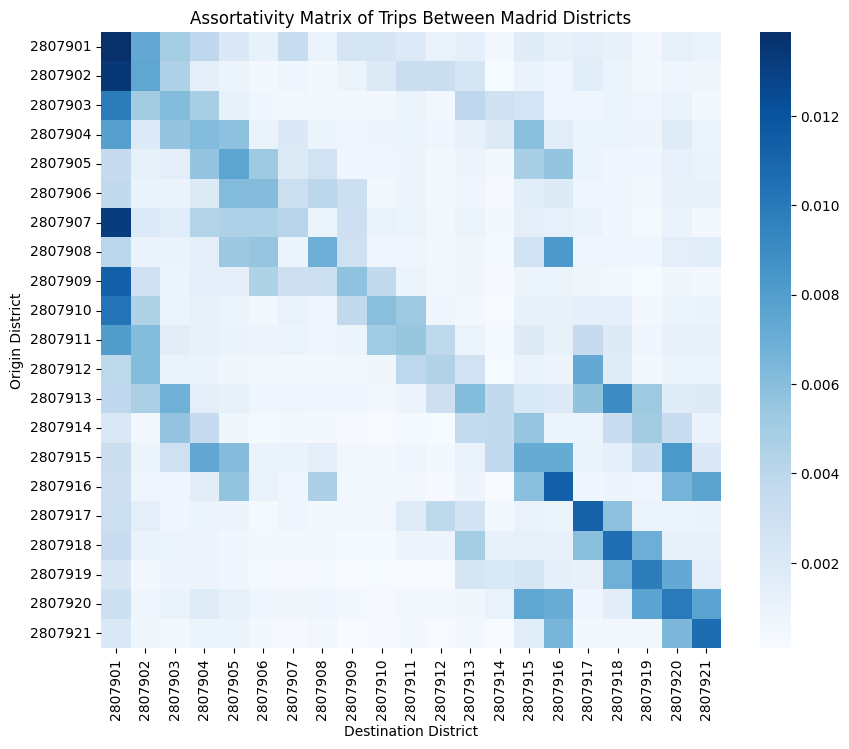

In [42]:
# Create a heatmap of the normalized assortativity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(A_normalized, xticklabels=districts, yticklabels=districts, cmap='Blues', annot=False)
plt.title('Assortativity Matrix of Trips Between Madrid Districts')
plt.xlabel('Destination District')
plt.ylabel('Origin District')
plt.show()
